In [93]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

# for type hinting
from typing import List

# for pearson corr coef and p values
from scipy.stats import pearsonr

# For plotting relationships
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns


# for non linear coefficients
from scipy.stats import spearmanr
from scipy.spatial.distance import squareform, pdist
from sklearn.feature_selection import mutual_info_regression

In [2]:
# for cuda core use but not installing......
#import cupy as cp

In [10]:
# Load data from CSV
df = pd.read_csv('D:\GitHub\MSc-Project-March\SWaT DataSWaT 10 sec.csv')


In [11]:
#df = df.drop(['P101', 'P102', 'P201', 'P202', 'P204', 'P206', 'P401', 'P403', 'P404', 'P502', 'P601', 'P603'], axis=1)

In [12]:
#df = df.drop(['Unnamed: 0'], axis=1)

In [13]:
#df = df.drop(['Timestamp'], axis=1)

In [20]:
df.head()

,FIT101,LIT101,MV101,P101,AIT201,AIT202,AIT203,FIT201,MV201,P203,...,FIT501,FIT502,FIT503,FIT504,P501,PIT501,PIT502,PIT503,FIT601,P602
0,0.0,123.97593,1.0,1.0,251.9226,8.313061,312.79160,0.0,1.0,1.0,...,0.001538,0.001409,0.001664,0.0,1.0,9.100231,0.0,3.3485,0.000256,1.0
1,0.0,124.40769,1.0,1.0,251.9226,8.308960,312.90185,0.0,1.0,1.0,...,0.001538,0.001409,0.001664,0.0,1.0,9.100231,0.0,3.3485,0.000256,1.0
2,0.0,123.90527,1.0,1.0,251.9226,8.310979,312.80442,0.0,1.0,1.0,...,0.001538,0.001409,0.001664,0.0,1.0,9.100231,0.0,3.3485,0.000256,1.0
3,0.0,123.90134,1.0,1.0,251.9226,8.312612,312.91980,0.0,1.0,1.0,...,0.001538,0.001409,0.001664,0.0,1.0,9.037747,0.0,3.3485,0.000256,1.0
4,0.0,124.85909,1.0,1.0,251.9226,8.308191,313.00950,0.0,1.0,1.0,...,0.001538,0.001409,0.001664,0.0,1.0,9.068188,0.0,3.3485,0.000256,1.0


In [16]:
print(f"Date Range is from {df['date'].min()} to {df['date'].max()}")

Date Range is from 2015-12-22 to 2015-12-28


See range of values in each column so allow filtering of unchanging values before correlation matrix.

In [17]:
# Get columns
#column_names = df.columns
#rint(column_names)

In [18]:
def drop_static_columns(df: pd.DataFrame) -> (pd.DataFrame, List[str]):
    """
    Find columns in the DataFrame where all values are the same (static columns).

    Parameters:
        df (DataFrame): All values from SWaT .

    Returns:
        df (DataFrame): Columns from SWaT which have more than 1 value.

    Example:
        df = pd.DataFrame({'LIT101': [1.111, 2.222, 3.333], 'P101': [1, 1, 0], 'P102': [1, 1, 1]})
        static_cols = get_static_columns(df, ['A', 'B', 'C'])
        # static_cols will be ['P102'] since all values are 1.
    """
    column_names = df.columns
    static_columns = []
    for column in column_names:
        if df[column].min() == df[column].max():
            static_columns.append(column)

    df_cleaned = df.drop(columns= static_columns)
    return df_cleaned, static_columns


In [19]:
df_cleaned, dropped_columns = drop_static_columns(df)
print(dropped_columns)
# drop time and date
df_cleaned = df_cleaned.drop(columns= ['date', 'time'])
print(df_cleaned.columns)

['P102', 'P201', 'P202', 'P204', 'P206', 'P401', 'P403', 'P404', 'P502', 'P601', 'P603']
Index(['FIT101', 'LIT101', 'MV101', 'P101', 'AIT201', 'AIT202', 'AIT203',
       'FIT201', 'MV201', 'P203', 'P205', 'DPIT301', 'FIT301', 'LIT301',
       'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402',
       'FIT401', 'LIT401', 'P402', 'UV401', 'AIT501', 'AIT502', 'AIT503',
       'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'PIT501',
       'PIT502', 'PIT503', 'FIT601', 'P602'],
      dtype='object')


Styler might be worth it for formatting tables

In [76]:
#help(Styler)

In [22]:
# Display correlation matrix and p-values
#print("Correlation Matrix:")
#display(correlation_matrix_styled)
#print("\nP-values:")
#display(p_values_styled)

Use a class to hold knowledge about each component which can be updated throughout pipeline. Can include functions which return top antecendent/ dependent modules etc.

In [54]:
# class to act as knowledge object for each component in the system
class Component:
    def __init__(self, name, list_position, correlation_dict= None, p_value_dict= None, non_lin_correlation_dict= None, non_lin_p_value_dict = None ):
        self.name = name
        # position in results list
        self.list_position = list_position

        # empty dict for results from EDA for components relationship to all other components
        self.correlation_dict = correlation_dict if correlation_dict is not None else {}
        self.p_value_dict = p_value_dict if p_value_dict is not None else {}
        self.non_lin_correlation_dict = non_lin_correlation_dict if non_lin_correlation_dict is not None else {}
        self.non_lin_p_value_dict = non_lin_p_value_dict if p_value_dict is not None else {}

    def get_correlated_components(self, source_data= 'linear', lower_threshold= 0, upper_threshold= 1):
        """
        Returns correlations, takes optional min threshold argument (default is 1 for all values).

        Parameters:
        - threshold: The minimum correlation value.

        Returns:
        - A dictionary containing component names as keys and correlation values as values.
        """
        correlated_components = {}
        if source_data == 'linear':
            for component, correlation in self.correlation_dict.items():
                if component != self.name and  lower_threshold <= abs(correlation) <= upper_threshold:
                    correlated_components[component] = correlation
            return correlated_components

        if source_data == 'non_linear':
            correlated_components = {}
            for component, correlation in self.non_lin_correlation_dict.items():
                if component != self.name and  lower_threshold <= abs(correlation) <= upper_threshold:
                    correlated_components[component] = correlation
            return correlated_components

    def get_correlated_components_p_value(self, source_data= 'linear', lower_threshold= 0, upper_threshold= 0.05):
        """
        Returns correlated components by p-value, takes optional max threshold argument (default is 1 for all values).

        Parameters:
        - threshold: The minimum correlation value.

        Returns:
        - A dictionary containing component names as keys and p values as values.
        """
        correlated_components_p_value = {}

        if source_data == 'linear':
            for component, p_value in self.p_value_dict.items():
                if component != self.name and  lower_threshold <= p_value <= upper_threshold:
                    correlated_components_p_value[component] = p_value
            return correlated_components_p_value

        if source_data == 'non_linear':
            for component, p_value in self.non_lin_p_value_dict.items():
                if component != self.name and  lower_threshold <= p_value <= upper_threshold:
                    correlated_components_p_value[component] = p_value
            return correlated_components_p_value


    def plot_network(self, source_data= 'correlation_matrix',lower_threshold= 0.5, upper_threshold= 1, layout= nx.spring_layout ):
        """
        Plot a network of components linked by correlation strength above a certain threshold.
        """
        # Create a graph
        G = nx.Graph()

        if source_data == 'correlation_matrix':
            # Add nodes (components) and edges ( correlation)
            for component, correlation in self.get_correlated_components('linear', lower_threshold,upper_threshold).items():
                G.add_node(component, correlation_strength=correlation)
                G.add_edge(self.name, component, weight= correlation)
            # Set title
            plt.title(f"Network of Components Linked by Correlation Strength (upper_threshold: {upper_threshold}, lower_threshold: {lower_threshold})")

        elif source_data == 'correlation_p_value':
            # Add nodes (components) and edges ( correlation)
            for component, p_value in self.get_correlated_components_p_value('linear', lower_threshold, upper_threshold).items():
                G.add_node(component, correlation_strength= p_value)
                G.add_edge(self.name, component, weight= p_value)

            # Set title
            plt.title(f"Network of Components Linked by P Value (upper_threshold: {upper_threshold}, lower_threshold: {lower_threshold})")

        if source_data == 'non_lin_correlation':
            # Add nodes (components) and edges ( correlation)
            for component, correlation in self.get_correlated_components('non_linear', lower_threshold,upper_threshold).items():
                G.add_node(component, correlation_strength=correlation)
                G.add_edge(self.name, component, weight= correlation)
            # Set title
            plt.title(f"Network of Components Linked by Non Linear Correlation Strength (upper_threshold: {upper_threshold}, lower_threshold: {lower_threshold})")

        elif source_data == 'non_lin_correlation_p_value':
            # Add nodes (components) and edges ( correlation)
            for component, p_value in self.get_correlated_components_p_value('non_linear', lower_threshold,upper_threshold).items():
                G.add_node(component, correlation_strength= p_value)
                G.add_edge(self.name, component, weight= p_value)
            # Set title
            plt.title(f"Network of Components Linked by Non Linear P Value (upper_threshold: {upper_threshold}, lower_threshold: {lower_threshold})")



        # Draw the graph
        pos = layout(G)  # Use layout argument if passed
        nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold')
        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

        # Show the plot
        plt.show()

In [55]:
# iterate through every column and create object of component class
# dictionary for all components
components = {}
for n, component in enumerate(df_cleaned.columns):
    # print(n, component)
    components[component] = Component(name= component, list_position= n)


In [21]:
# Calculate the linear correlation matrix
correlation_matrix = df_cleaned.corr().round(decimals= 4)

# DataFrame to store p-values with rows and cols being column names
p_values = pd.DataFrame(index=df_cleaned.columns, columns=df_cleaned.columns)

# Calculate p-values
# for every column
for col1 in df_cleaned.columns:
    # calculate values with everyother column
    for col2 in df_cleaned.columns:
        correlation_coefficient, p_value = pearsonr(df_cleaned[col1], df_cleaned[col2])
        # Save values to corresponding location in p_values df, rounded to 4.d.p
        p_values.loc[col1, col2] = round(p_value, 4)

# Apply a color gradient to the correlation matrix and display it
correlation_matrix_styled  = correlation_matrix.style.background_gradient(cmap='coolwarm').format(precision= 2)
p_values_styled  = p_values.style.background_gradient(cmap='coolwarm').format(precision= 2)



In [58]:
#index_values = correlation_matrix.index.values
#print(index_values)

In [28]:
specific_component = components['LIT101']
#specific_component.correlation_list
#specific_component.correlation_dict

In [29]:
#specific_component.get_correlated_components(0.2,1)

In [59]:
# Calculate the correlation matrix using Spearman's rank correlation
non_lin_correlation_matrix = df_cleaned.corr(method='spearman').round(decimals=4)

# DataFrame to store p-values with rows and cols being column names
non_lin_p_values = pd.DataFrame(index=df_cleaned.columns, columns=df_cleaned.columns)

# Calculate p-values
# for every column
for col1 in df_cleaned.columns:
    # calculate values with every other column
    for col2 in df_cleaned.columns:
        correlation_coefficient, p_value = spearmanr(df_cleaned[col1], df_cleaned[col2])
        # Save values to corresponding location in p_values df, rounded to 4.d.p
        non_lin_p_values.loc[col1, col2] = round(p_value, 4)

# Apply a color gradient to the correlation matrix and display it
non_lin_correlation_matrix_styled = non_lin_correlation_matrix.style.background_gradient(cmap='coolwarm').format(precision=2)
non_lin_p_values_styled = non_lin_p_values.style.background_gradient(cmap='coolwarm').format(precision=2)


In [89]:
# Calculate mutual information between features
mutual_info_matrix = pd.DataFrame(index=df_cleaned.columns, columns=df_cleaned.columns)

# Calculate mutual information
for col1 in df_cleaned.columns:
    for col2 in df_cleaned.columns:
        mutual_info = mutual_info_regression(df_cleaned[[col1]], df_cleaned[col2])[0]
        mutual_info_matrix.loc[col1, col2] = mutual_info

# Display the mutual information matrix
print(mutual_info_matrix)


           FIT101    LIT101     MV101      P101    AIT201    AIT202    AIT203  \
FIT101   7.180684  0.327507  0.605045  0.022882  0.088175  0.048489  0.102725   
LIT101   0.327533  9.472041  0.339545  0.328444  0.611531  0.505028  0.687082   
MV101    0.604757  0.338966  0.649998  0.027464   0.08368  0.048729   0.10675   
P101      0.02139  0.329689  0.026986   0.59472  0.097048  0.489372  0.425762   
AIT201   0.089678  0.611942  0.082814  0.094458  6.112804  1.321178  1.743097   
AIT202   0.048251  0.505625  0.051225  0.490462  1.321795  8.213883  0.985469   
AIT203   0.103107  0.686914  0.106973  0.429932  1.742283  0.985271  8.264514   
FIT201   0.097791  0.618099  0.104709  0.574289   0.66217  0.639111  0.677754   
MV201    0.027236  0.334089  0.031133  0.583183  0.096801  0.494518  0.428898   
P203     0.030732  0.341409  0.027918  0.568613  0.096617  0.503614  0.433493   
P205     0.013254  0.251244  0.018721  0.385072  0.159788  0.376136  0.525102   
DPIT301  0.067437  0.393171 

In [57]:
# Assuming components is a dictionary with component names as keys and Component objects as values
for component_name, component_obj in components.items():
    # Convert correlation coefficient row to dictionary with row index and value
    correlation_dict = {col: value for col, value in zip(correlation_matrix.columns, correlation_matrix.loc[component_name])}
    component_obj.correlation_dict = correlation_dict
    print(component_name, component_obj.correlation_dict )

    # Convert p-value row to dictionary with row index and value
    p_value_dict = {col: value for col, value in zip(p_values.columns, p_values.loc[component_name])}
    #p_value_dict = {index: value for index, value in enumerate(p_values.loc[component_name])}
    component_obj.p_value_dict = p_value_dict

FIT101 {'FIT101': 1.0, 'LIT101': -0.6478, 'MV101': 0.9805, 'P101': 0.2205, 'AIT201': -0.0021, 'AIT202': -0.0864, 'AIT203': 0.032, 'FIT201': 0.2267, 'MV201': 0.2223, 'P203': 0.2287, 'P205': 0.1672, 'DPIT301': -0.202, 'FIT301': -0.2092, 'LIT301': 0.3514, 'MV301': 0.0364, 'MV302': -0.1873, 'MV303': 0.0768, 'MV304': 0.0108, 'P301': 0.0371, 'P302': -0.2233, 'AIT401': -0.0275, 'AIT402': 0.0685, 'FIT401': 0.0251, 'LIT401': 0.4062, 'P402': 0.0177, 'UV401': 0.0177, 'AIT501': -0.0245, 'AIT502': 0.0716, 'AIT503': 0.1096, 'AIT504': -0.0109, 'FIT501': 0.0253, 'FIT502': 0.0269, 'FIT503': 0.0155, 'FIT504': 0.0048, 'P501': 0.0155, 'PIT501': 0.0266, 'PIT502': 0.0542, 'PIT503': 0.0284, 'FIT601': 0.0589, 'P602': 0.0565}
LIT101 {'FIT101': -0.6478, 'LIT101': 1.0, 'MV101': -0.6527, 'P101': -0.6587, 'AIT201': 0.0044, 'AIT202': 0.2195, 'AIT203': -0.138, 'FIT201': -0.6668, 'MV201': -0.6591, 'P203': -0.6671, 'P205': -0.4893, 'DPIT301': -0.1531, 'FIT301': -0.1511, 'LIT301': 0.1817, 'MV301': -0.0416, 'MV302': -0.

In [65]:
# Assuming components is a dictionary with component names as keys and Component objects as values
for component_name, component_obj in components.items():
    # Convert correlation coefficient row to dictionary with row index and value
    non_lin_correlation_dict = {col: value for col, value in zip(non_lin_correlation_matrix.columns, non_lin_correlation_matrix.loc[component_name])}
    component_obj.non_lin_correlation_dict = non_lin_correlation_dict
    print(component_name, component_obj.non_lin_correlation_dict )

    # Convert p-value row to dictionary with row index and value
    non_lin_p_value_dict = {col: value for col, value in zip(non_lin_p_values.columns, non_lin_p_values.loc[component_name])}
    #p_value_dict = {index: value for index, value in enumerate(p_values.loc[component_name])}
    component_obj.non_lin_p_value_dict = non_lin_p_value_dict

FIT101 {'FIT101': 1.0, 'LIT101': -0.488, 'MV101': 0.774, 'P101': 0.1751, 'AIT201': -0.0131, 'AIT202': -0.1574, 'AIT203': 0.0006, 'FIT201': -0.0134, 'MV201': 0.1766, 'P203': 0.1814, 'P205': 0.1311, 'DPIT301': -0.1721, 'FIT301': -0.1026, 'LIT301': 0.3733, 'MV301': 0.0123, 'MV302': -0.1468, 'MV303': 0.0457, 'MV304': 0.0117, 'P301': 0.0322, 'P302': -0.1728, 'AIT401': -0.0096, 'AIT402': 0.0603, 'FIT401': 0.0479, 'LIT401': 0.4899, 'P402': 0.0122, 'UV401': 0.0124, 'AIT501': -0.005, 'AIT502': 0.0758, 'AIT503': 0.1009, 'AIT504': 0.0213, 'FIT501': 0.0485, 'FIT502': 0.0314, 'FIT503': 0.0003, 'FIT504': -0.0653, 'P501': 0.0104, 'PIT501': 0.0362, 'PIT502': 0.0719, 'PIT503': 0.0383, 'FIT601': -0.0048, 'P602': 0.0467}
LIT101 {'FIT101': -0.488, 'LIT101': 1.0, 'MV101': -0.6239, 'P101': -0.641, 'AIT201': -0.0061, 'AIT202': 0.5272, 'AIT203': -0.3624, 'FIT201': -0.389, 'MV201': -0.6422, 'P203': -0.6471, 'P205': -0.4798, 'DPIT301': -0.127, 'FIT301': -0.0678, 'LIT301': 0.1962, 'MV301': -0.0255, 'MV302': -0.1

# Visualising Relationships

In [66]:
df_cleaned.shape

(49500, 40)

In [67]:
#specific_component.get_correlated_components('linear',0.01, 1)

In [68]:
len(specific_component.get_correlated_components('linear', 0.01, 1))

38

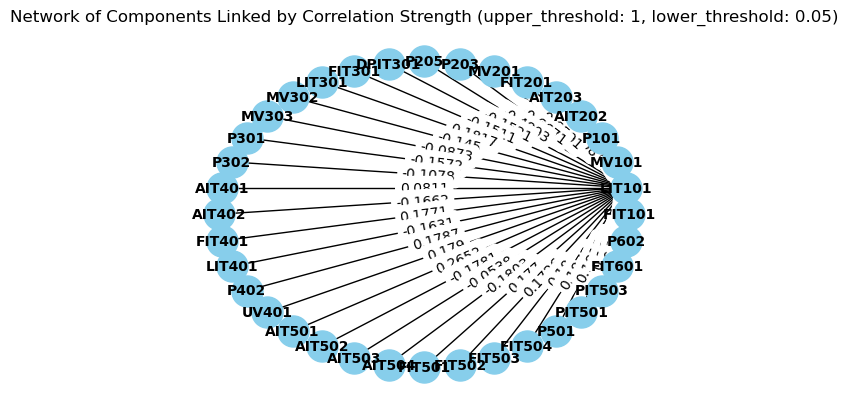

In [69]:
specific_component.plot_network('correlation_matrix', 0.05, 1, nx.circular_layout )

In [70]:
len(specific_component.get_correlated_components('linear', 0.6, 1))

6

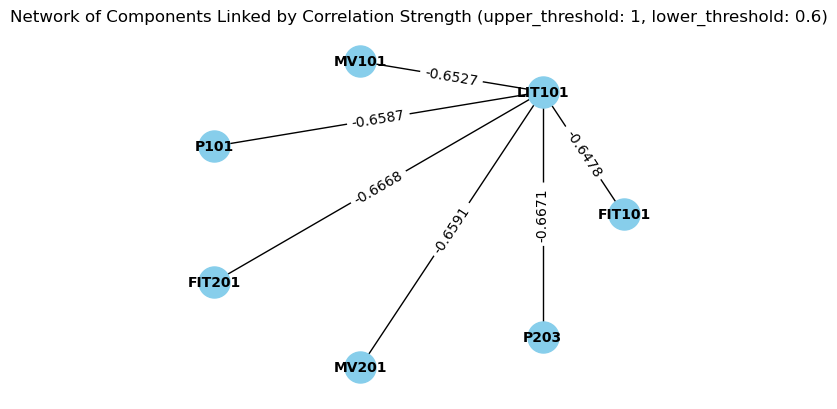

In [71]:
specific_component.plot_network('correlation_matrix', 0.6, 1, nx.circular_layout )

In [72]:
specific_component.get_correlated_components_p_value('linear', 0.0, 0.05)

{'FIT101': 0.0,
 'MV101': 0.0,
 'P101': 0.0,
 'AIT202': 0.0,
 'AIT203': 0.0,
 'FIT201': 0.0,
 'MV201': 0.0,
 'P203': 0.0,
 'P205': 0.0,
 'DPIT301': 0.0,
 'FIT301': 0.0,
 'LIT301': 0.0,
 'MV301': 0.0,
 'MV302': 0.0,
 'MV303': 0.0,
 'MV304': 0.0037,
 'P301': 0.0,
 'P302': 0.0,
 'AIT401': 0.0,
 'AIT402': 0.0,
 'FIT401': 0.0,
 'LIT401': 0.0,
 'P402': 0.0,
 'UV401': 0.0,
 'AIT501': 0.0,
 'AIT502': 0.0,
 'AIT503': 0.0,
 'AIT504': 0.0,
 'FIT501': 0.0,
 'FIT502': 0.0,
 'FIT503': 0.0,
 'FIT504': 0.0,
 'P501': 0.0,
 'PIT501': 0.0,
 'PIT502': 0.0,
 'PIT503': 0.0,
 'FIT601': 0.0,
 'P602': 0.0}

In [73]:
 len(specific_component.get_correlated_components_p_value('linear', 0.0, 0.05))

38

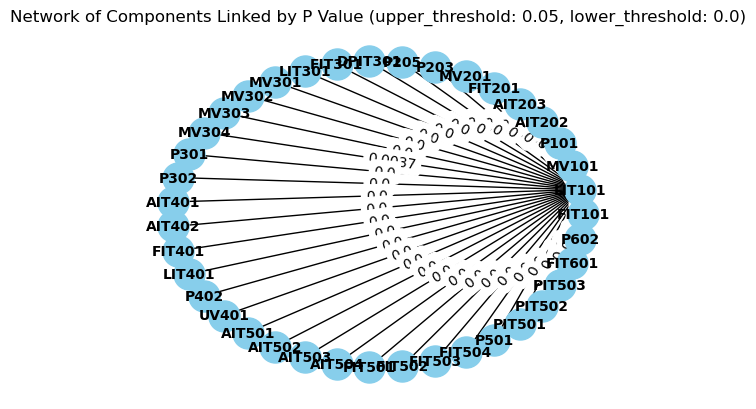

In [74]:
specific_component.plot_network('correlation_p_value', 0.0, 0.05, nx.circular_layout )

## Observations
P value ( statistical significance) value of 5% indicates 38 of 39 components disprove the null hypothesis that the relationship between components is random. This numebr of related components is acheived by using a Pearson correlation coefficient 0f 0.01 or above ( a very week linear correlation).
These Values were calculated from the correlation from the LIT101 water level sensor which is the main water tank at the beginning of the process ( and so is understandably linked to all other components to some degree.
Restricted the results to correlation coefficients above 0.6 identifies 5 componnets with strong correlations, all of which are in the same or following stage and are related to the movement of water ( pumps or flow sensors). This suggests the Pearson values are more useful is revelaing system dependencies.


# Non-Linear Correlation of Components
The previous stage looked for linear correlation between components, other non- linear methods were evaluated as the complex interplay of componets could lead to non-linear behaviour even with pairwise linear relationships. These methods look for monatonic relationships- the values for two components consistently change together ( positive or negative).

In [75]:
# Display correlation matrix and p-values
#print("non_lin Correlation Matrix:")
#display(non_lin_correlation_matrix_styled)


In [76]:
#non_lin_p_values_styled

In [77]:
specific_component.get_correlated_components('non_linear', 0.6, 1)

{'MV101': -0.6239, 'P101': -0.641, 'MV201': -0.6422, 'P203': -0.6471}

In [78]:
len(specific_component.get_correlated_components('non_linear', 0.6, 1))

4

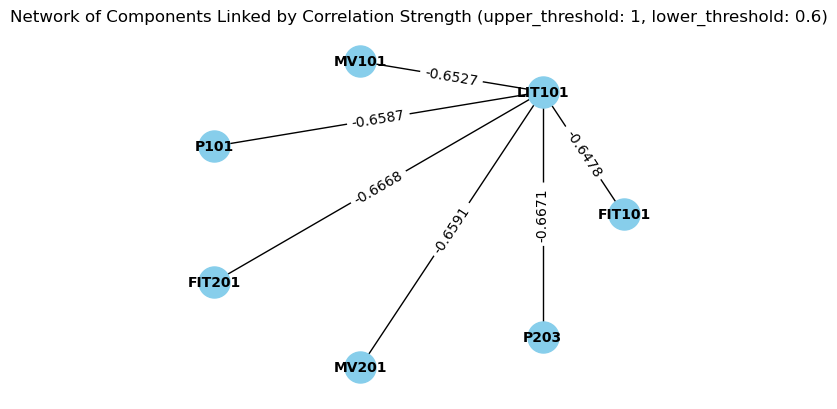

In [79]:
specific_component.plot_network('correlation_matrix', 0.6, 1, nx.circular_layout )

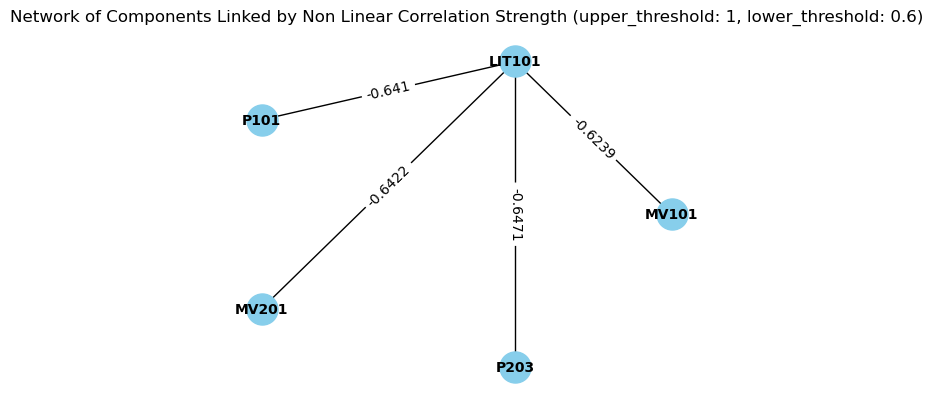

In [80]:
specific_component.plot_network('non_lin_correlation', 0.6, 1, nx.circular_layout )

In [90]:
# Add type of correlation to each matrix
correlation_matrix['Correlation Type'] = 'Pearson'
non_lin_correlation_matrix['Correlation Type'] = 'Spearman'
mutual_info_matrix['Correlation Type'] = 'Mutal_Info'

In [91]:
# Concatenate two correlation matrices vertically
merged_correlation_matrix = pd.concat([correlation_matrix, non_lin_correlation_matrix, mutual_info_matrix])

# Display the merged correlation matrix
#print(merged_correlation_matrix)

In [105]:
# Get rows for the component named "LIT101" from the merged correlation matrix
rows_for_LIT101 = merged_correlation_matrix.loc["LIT101"]

# Display the rows for LIT101
print(rows_for_LIT101.head())

          FIT101    LIT101     MV101      P101    AIT201    AIT202    AIT203  \
LIT101   -0.6478       1.0   -0.6527   -0.6587    0.0044    0.2195    -0.138   
LIT101    -0.488       1.0   -0.6239    -0.641   -0.0061    0.5272   -0.3624   
LIT101  0.327533  9.472041  0.339545  0.328444  0.611531  0.505028  0.687082   

          FIT201     MV201     P203  ...  FIT502    FIT503    FIT504     P501  \
LIT101   -0.6668   -0.6591  -0.6671  ...  0.1726      0.18    0.1875   0.1818   
LIT101    -0.389   -0.6422  -0.6471  ...  0.0261   -0.0241     0.012   0.0965   
LIT101  0.618014  0.334412  0.34183  ...  0.0614  0.102009  0.123926  0.02073   

          PIT501    PIT502    PIT503    FIT601      P602 Correlation Type  
LIT101     0.166   -0.0271     0.162   -0.0676   -0.0648          Pearson  
LIT101   -0.0423   -0.0622   -0.0426   -0.0517    -0.099         Spearman  
LIT101  0.140805  0.118663  0.147261  0.053608  0.017319       Mutal_Info  

[3 rows x 41 columns]


In [108]:
display(rows_for_LIT101)

,FIT101,LIT101,MV101,P101,AIT201,AIT202,AIT203,FIT201,MV201,P203,...,FIT502,FIT503,FIT504,P501,PIT501,PIT502,PIT503,FIT601,P602,Correlation Type
LIT101,-0.6478,1.0,-0.6527,-0.6587,0.0044,0.2195,-0.138,-0.6668,-0.6591,-0.6671,...,0.1726,0.18,0.1875,0.1818,0.166,-0.0271,0.162,-0.0676,-0.0648,Pearson
LIT101,-0.488,1.0,-0.6239,-0.641,-0.0061,0.5272,-0.3624,-0.389,-0.6422,-0.6471,...,0.0261,-0.0241,0.012,0.0965,-0.0423,-0.0622,-0.0426,-0.0517,-0.099,Spearman
LIT101,0.327533,9.472041,0.339545,0.328444,0.611531,0.505028,0.687082,0.618014,0.334412,0.34183,...,0.0614,0.102009,0.123926,0.02073,0.140805,0.118663,0.147261,0.053608,0.017319,Mutal_Info


# Original Section

Get distributions for each variable. Get range, divide into 100 bins then count variables ineach. Visualise in plot

In [104]:
# Create masks for Spearman and Mutual Information correlations higher than Pearson
spearman_higher_mask = non_lin_correlation_matrix > correlation_matrix
mutual_info_higher_mask = mutual_info_matrix > correlation_matrix

# Extract values where Spearman correlation is higher than Pearson
spearman_higher_values = non_lin_correlation_matrix[spearman_higher_mask]

# Extract values where Mutual Information correlation is higher than Pearson
mutual_info_higher_values = mutual_info_matrix[mutual_info_higher_mask]

# Combine the extracted values
higher_values = pd.concat([spearman_higher_values, mutual_info_higher_values])

# Plot the higher values
plt.figure(figsize=(10, 6))
sns.barplot(x=higher_values.index, y=higher_values.values, palette='coolwarm')
plt.title('Values where Spearman or Mutual Info are higher than Pearson')
plt.xlabel('Component Pair')
plt.ylabel('Correlation Value')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


TypeError: Neither the `x` nor `y` variable appears to be numeric.

<Figure size 1000x600 with 0 Axes>

In [95]:
# make new df to hold variable distributions
df_distributions = pd.DataFrame()

Sample df as 10 second mean for all values so df is 10% of original to east manipulation

In [96]:
def plotBinCounts(name, bin_counts, bin_edges):
    '''
    Function to plot the distribution of bin counts.
    Parameters:
    - bin_counts: a pandas Series containing the counts of values in each bin.
    - bin_edges: an array containing the bin edges.
    '''

    # Set the size of the plot
    plt.figure(figsize=(10,6))

    # Plot the bin counts
    bin_counts.plot(kind='bar', logy=True)

    # Set the title and labels
    plt.title(f'Distribution of {name}')
    plt.ylabel('Counts')

    # Calculate total range and step size for approximately 10 divisions
    total_range = bin_edges[-1] - bin_edges[0]
    step_size = total_range / 10

    # Round step size to a whole number (e.g., 10, 20, etc.) that makes sense for your data
    rounded_step_size = round(step_size / 10) * 10

    # Generate custom tick positions and labels
    tick_positions = np.arange(0, len(bin_edges) - 1, rounded_step_size / (bin_edges[1] - bin_edges[0]))
    tick_labels = [f"{bin_edges[int(pos)]:.0f}" for pos in tick_positions]

    # Set x-ticks to represent the overall value range of the bins
    plt.xticks(ticks=tick_positions,
               labels=tick_labels,
               rotation=45)  # Rotate labels for better readability

    # Optional: Set x-axis label
    plt.xlabel('Value Range')

    # Show the plot
    plt.show()

# Example usage:
# Assuming bin_counts and bins are obtained from the getDistribution function
# plotBinCounts(bin_counts, bins)


In [97]:
# function to get distribution
def getDistribution(variable_col):
    '''
    Function to get distribution of values in variable column.
    Returns
    '''
    #get variable min and max values and calculate range

    var_range = df[variable_col].max() - df[variable_col].min()

    print(f'Var Range:  {var_range}')

    # divide into 100 bins
    bin_size = var_range/100

    # Create bins edges from min to max with using bin_size'
    bins = np.arange(df[variable_col].min(), df[variable_col].max() + bin_size, bin_size)

    # Use pd.cut to segment and sort the data values into bins
    df_distributions[variable_col + '_bins'] = pd.cut(df[variable_col], bins=bins, include_lowest=True)

    # Count the number of values in each bin
    bin_counts = df_distributions[variable_col + '_bins'].value_counts().sort_index()

    # call sisualisation function
    plotBinCounts(variable_col, bin_counts, bins)

    # return bin_counts, bins

Var Range:  696.22615


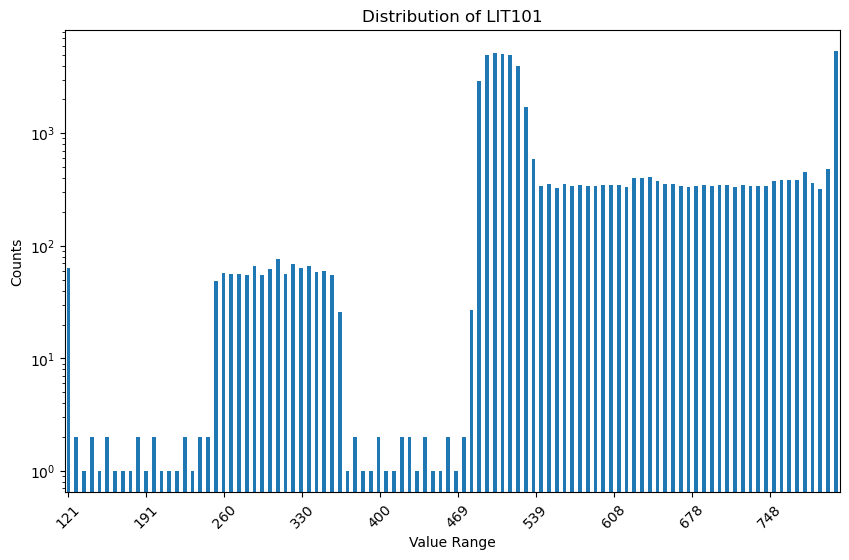

In [98]:
# test with FIT101
#lit101_dist, bins = getDistribution('LIT101')
#plotBinCounts(lit101_dist, bins)

getDistribution('LIT101')

1,FIT-101,Sensor,Flow meter; Measures inflow into raw water tank.
2,LIT-101,Sensor,Level Transmitter; Raw water tank level.
3,MV-101,Actuator,Motorized valve; Controls water flow to the raw water tank.

Var Range:  1.9


C:\Users\laure\AppData\Local\Temp\ipykernel_2536\2836748902.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  tick_positions = np.arange(0, len(bin_edges) - 1, rounded_step_size / (bin_edges[1] - bin_edges[0]))


ValueError: Maximum allowed size exceeded

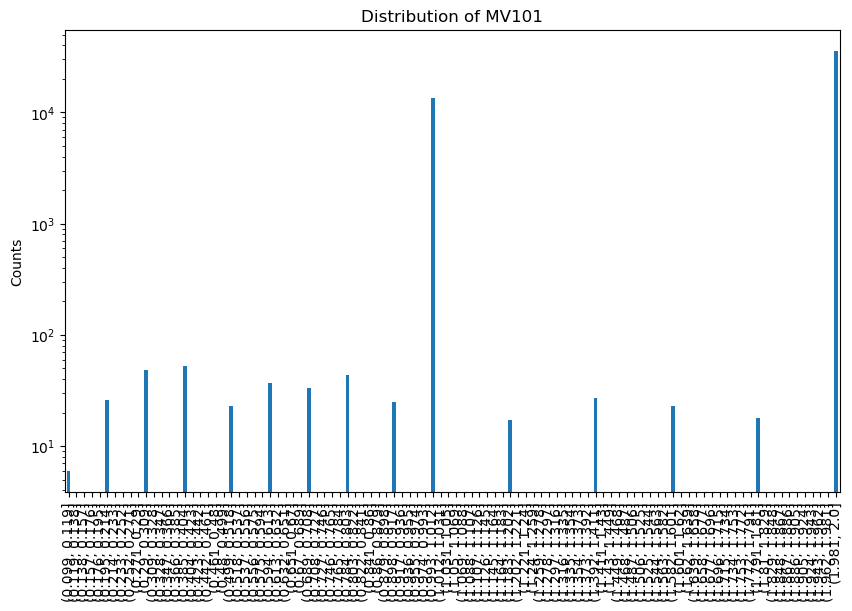

In [105]:
getDistribution('MV101')

Var Range:  2.6828618


C:\Users\laure\AppData\Local\Temp\ipykernel_2536\2836748902.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  tick_positions = np.arange(0, len(bin_edges) - 1, rounded_step_size / (bin_edges[1] - bin_edges[0]))


ValueError: Maximum allowed size exceeded

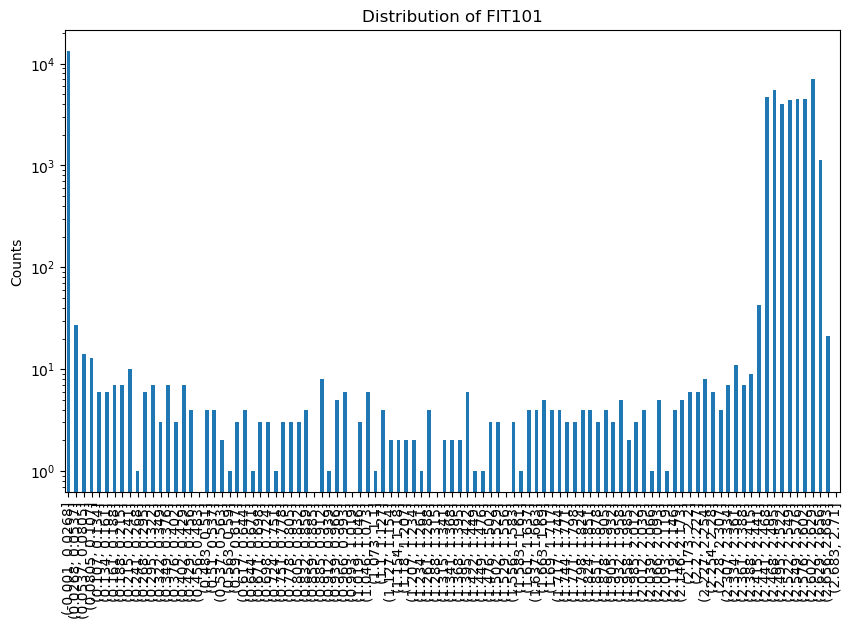

In [106]:
getDistribution('FIT101')

Var Range:  1.0


C:\Users\laure\AppData\Local\Temp\ipykernel_2536\2836748902.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  tick_positions = np.arange(0, len(bin_edges) - 1, rounded_step_size / (bin_edges[1] - bin_edges[0]))


ValueError: Maximum allowed size exceeded

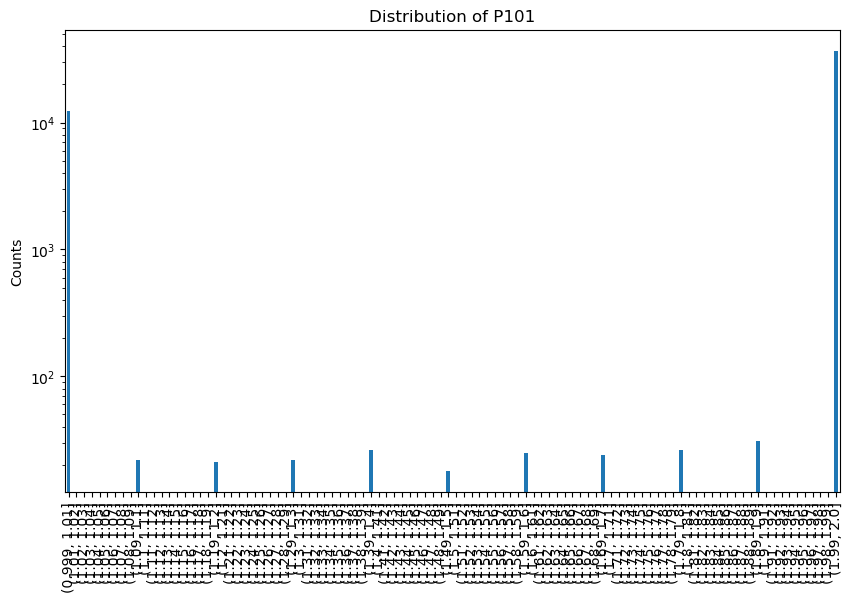

In [107]:
getDistribution('P101')